Описание содержания проекта по разработке сервиса предсказания суточного объема потребления и транспортировки природного газа.

Цель проекта: Разработка сервиса необходима для повышения уровня прогнозирования объемов транспортировки и потребления природного газа с последующим увеличением показателей планово-экономической деятельности.

Описание сервиса: Продукт будет построен на основе ML алгоритма, позволяющего прогнозировать объемы транспортировки и потребления природного газа с точностью выше, чем алгоритм, основанный на расчете средней величины. В качестве данных, на которых будет обучаться модель мы используем датасеты, содержащие информацию о потреблении ПГ за периоды с 2016 по 2020 годы. 

Структура исходных датасетов следующая:
Дата потребления
	Потребитель 1	…Потребитель N	Группа потребителя
Для получения более точных результатов, датасет дополняем следующими «фичами»:
-	признак выходного/праздничного дня;
-	среднесуточная температура;
-	признак отопительного сезона;
-	другие признаки, генерируемые из вышеперечисленных.

Ключевые задачи проекта:
1)	Произвести EDA, FE
2)	Проверить несколько видов алгоритмов машинного обучения (Логистическая регрессия, XGBoost, Sarima)
3)	Получить лучшее метрики в сравнении с расчетом средней величины. Используемые метрики : MAE, MAPE, R2
4)	Разработка модели в продакшн.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings; warnings.simplefilter('ignore')
#import tensorflow as tf
import math
import xgboost

# Загружаем модуль для разделения датасета:
from sklearn.model_selection import train_test_split

# Загружаем соответствующие методы нормализации:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Загружаем метод создания полиномаиальных признаков:
from sklearn.preprocessing import PolynomialFeatures

# Загружаем модули для работы с датой и временем
from datetime import datetime
from datetime import timedelta

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler


In [2]:
pip install --upgrade xgboost


In [4]:
data = pd.read_excel('FinalDataSet.xlsx', sheet_name='3') 

## EDA

Изучим полученный датасет

In [21]:
data.shape

(365, 24)

Удалим столбцы с повторяющимимся значениями, так как они не информативны

In [19]:
for col in data.columns: 
    if (len(data[col].unique()) < 30): 
        if(col != 'holiday'):
            data = data.drop(col, axis = 'columns')

Проверим дата сет на пропуски

In [25]:
data.isna().sum().sort_values()

date                                                    0
АО ПО Оргхим, ИНН: 5235004482                           0
АО ОКБМ Африкантов, ИНН: 5259077666                     0
ООО Синтез ОКА, ИНН: 5249079128                         0
ОАО Теплоэнерго г.Н.Новгорода, ИНН: 5257087027.5        0
ОАО Теплоэнерго г.Н.Новгорода, ИНН: 5257087027.4        0
ОАО Теплоэнерго г.Н.Новгорода, ИНН: 5257087027.3        0
ОАО Теплоэнерго г.Н.Новгорода, ИНН: 5257087027.2        0
ОАО Теплоэнерго г.Н.Новгорода, ИНН: 5257087027.1        0
ОАО Теплоэнерго г.Н.Новгорода, ИНН: 5257087027          0
ПАО Русполимет, ИНН: 5251008501                         0
АО РСК МиГ, ИНН: 7714733528.1                           0
МУ Теплоэнергетическое ПП г Арзамас, ИНН: 5243000467    0
МУП Тепловодоканал г.Заволжья, ИНН: 5248016372          0
АО Корунд-Системы, ИНН: 5249076649                      0
ООО УК НОКК (Володарский филиал), ИНН: 7714740243       0
АО РСК МиГ, ИНН: 7714733528                             0
ПАО Завод Крас

In [24]:
#заполним пропуски при необходимости средним
#data = data.dropna(axis = 1, how = 'all', thresh=250)
data = data.fillna(data.median())
#data = data.dropna(axis = 0)


In [30]:
#опишем функцию по устранению выбросов
def cut_emissions(x):
    median = x.median()
    IQR = x.quantile(0.75) - x.quantile(0.25)
    perc25 = x.quantile(0.25)
    perc75 = x.quantile(0.75)
    x = x.loc[x.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
    return x

#создадим новый датафрейм, удалим категорильаные признаки
#data1 = data
#data1.drop(['holiday','temp','date','month','dayofweek','day'], inplace = True, axis = 1)


посмотрим на корреляции

<AxesSubplot:>

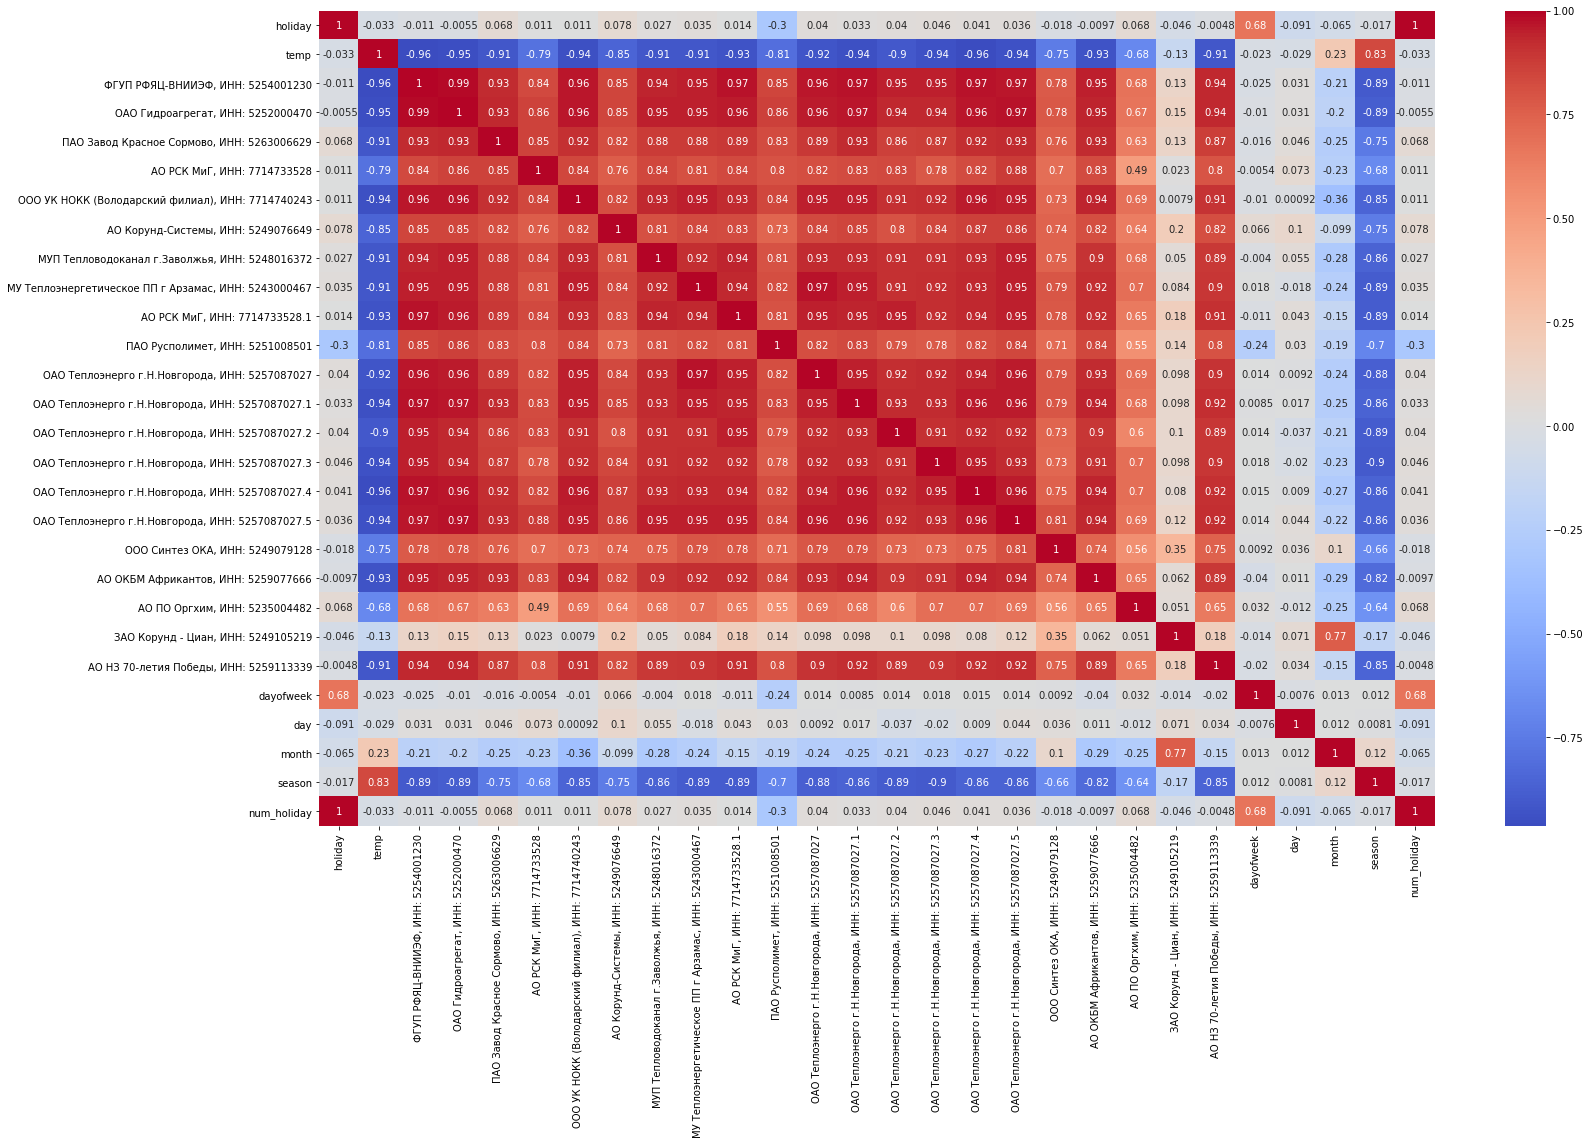

In [31]:
correlation = data.corr()
plt.rcParams['figure.figsize'] = (25,15)
sns.heatmap(correlation, annot = True, cmap = 'coolwarm')

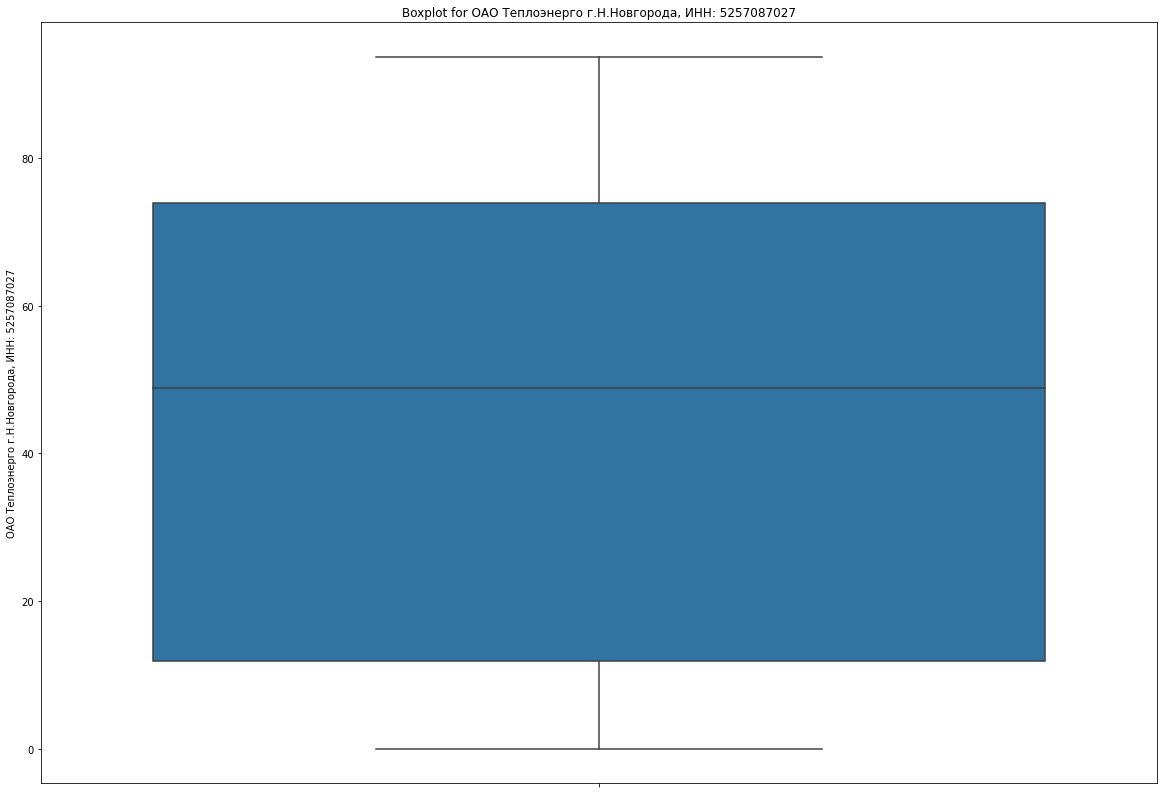

In [5]:
def get_boxplot(col):
    fig, ax = plt.subplots(figsize = (20, 14))
    sns.boxplot(y= col, data = data)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + col)
    plt.show()
for col in ['ОАО Теплоэнерго г.Н.Новгорода, ИНН: 5257087027']:
   get_boxplot(col)

## FE

Добавим чиcловой признак дня недели, дня, месяца

In [6]:
data['dayofweek'] = data['date'].dt.dayofweek
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month

добавим признак отопительного сезона

In [7]:
data['season'] = data['month'].apply(lambda x: 1 if x > 9 else 1 if x < 5 else 2)

оцифруем столбец 'Признак выходного дня'

In [8]:
label_encoder = LabelEncoder()
data['num_holiday'] = pd.Series(label_encoder.fit_transform(data['holiday']))

In [9]:
data['temperature'] = data['temp']
data.drop(['holiday','date','temp'], inplace = True, axis = 1)


## ML

In [ ]:
# опищем функцию кроссвалидации
def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3)

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen=24 * 7,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))

In [138]:
#создадим массив для зависимой переменной
Y = data.iloc[:,2:-24].values

#создадим массив для переменных-признаков]
X = data.iloc[:,21:].values


In [10]:
data

,"ФГУП РФЯЦ-ВНИИЭФ, ИНН: 5254001230","ОАО Гидроагрегат, ИНН: 5252000470","ПАО Завод Красное Сормово, ИНН: 5263006629","АО РСК МиГ, ИНН: 7714733528","ООО УК НОКК (Володарский филиал), ИНН: 7714740243","АО Корунд-Системы, ИНН: 5249076649","МУП Тепловодоканал г.Заволжья, ИНН: 5248016372","СОБСТВЕННЫЕ НУЖДЫ, ИНН:","ТЕХНОЛОГИЧЕСКИЕ ПОТЕРИ, ИНН:","СОБСТВЕННЫЕ НУЖДЫ, ИНН:.1",...,"АО ОКБМ Африкантов, ИНН: 5259077666","АО ПО Оргхим, ИНН: 5235004482","ЗАО Корунд - Циан, ИНН: 5249105219","АО НЗ 70-летия Победы, ИНН: 5259113339",dayofweek,day,month,season,num_holiday,temperature
0,60.626,43.290,59.778,88.111,41.950,33.926,98.103,0.699,0.507,2.343,...,48.736,65.427,75.349,97.866,0,1,1,1,1,-3.3
1,59.462,43.114,59.518,87.809,36.988,35.467,95.519,0.698,0.507,2.343,...,49.126,65.207,75.660,97.379,1,2,1,1,1,-0.1
2,56.605,40.074,59.120,89.587,37.498,39.066,96.125,0.698,0.507,2.343,...,48.921,65.129,75.443,94.941,2,3,1,1,1,1.1
3,64.171,45.658,59.396,91.826,43.255,40.757,109.683,0.698,0.507,2.343,...,50.161,65.918,75.342,102.989,3,4,1,1,1,1.4
4,73.732,54.924,59.827,94.774,51.587,43.834,126.882,0.698,0.507,2.343,...,51.269,67.607,75.039,113.821,4,5,1,1,1,-4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,89.619,66.793,76.105,111.379,48.416,52.812,160.322,0.586,0.527,2.459,...,64.903,66.240,142.272,153.599,3,27,12,1,0,-9.8
361,90.532,70.146,73.864,111.043,47.396,46.102,146.682,0.586,0.527,2.459,...,62.095,67.960,146.725,153.764,4,28,12,1,0,-11.6
362,84.469,63.842,69.096,111.027,50.929,54.071,151.164,0.586,0.527,2.459,...,61.434,65.890,151.064,144.878,5,29,12,1,0,-10.3
363,81.988,59.451,67.465,108.384,45.380,51.936,138.716,0.586,0.527,2.459,...,61.688,67.186,151.087,138.040,6,30,12,1,1,-13.3


In [141]:
# разобьем выборку на тестовую и обучаемую(80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [260]:
#нормализуем данные
#scaler = StandardScaler()
#scaler.fit_transform(data.iloc[:,:-5])

#нормализуем данные
#transformer_train = StandardScaler().fit(X_train)
#X_train = transformer_train.transform(X_train)

#transformer_test = StandardScaler().fit(X_test)
#X_test = transformer_test.transform(X_test)

In [142]:
# обучим модель
from sklearn.linear_model import LinearRegression
model_reg = LinearRegression() #Обозначаем, что наша модель - линейная регрессия
model_reg.fit(X_train,y_train) #обучаем модель на обучающих данных


LinearRegression()

In [116]:
model_boost = xgboost.XGBClassifier()
model_boost.fit(X_train, y_train)

[23:25:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [143]:
#предскажем значения расходов газа на тестовой выборке
y_pred = model_reg.predict(X_test)
y_pred = model_boost.predict(X_test)


In [134]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [144]:
#оценим ошибку предсказанной величины
from sklearn import metrics  # подгружаем метрики
print('MAE:',metrics.mean_absolute_error(Y_test, y_pred),
      'MAPE:', mean_absolute_percentage_error(Y_test, y_pred))

MAE: 10.079265071972582 MAPE: 135.52445477978588


In [1]:
#from sklearn.metrics import f1_score
#f1_score(Y_test, y_pred)

In [45]:
#вычислим коэффициент детерминации
R_2 = metrics.r2_score(Y_test, y_pred)
print(R_2)

0.9993957491411171
